# Clustering and Classification of MEPs' Tweets - Exercise Answers

In this set of exercises, we will be tackling preprocessing, clustering and classification problems.

> Dimitrios Stefanou <br />
> Α.Μ. 3160245

## Data Preparation

* Before else, we'll be importing all the libraries used in the notebook
* In case the file "tweets.csv" is not present on the same folder as the .ipynb, the Twitter API requires keys for the tweets' download

In [1]:
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import path
import seaborn as sn
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier

# Authenticate to Twitter
auth = tweepy.OAuthHandler("KEY", "SECRET_KEY")
auth.set_access_token("TOKEN","SECRET_TOKEN")
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
# test authentication
try:
    api.verify_credentials()
    print("Authentication OK.")
except:
    print("Error during authentication.")

Error during authentication.


* After importing, we read our dataset and drop everything not in English
* We create a lst of the tweet IDs we'll be downloading

In [2]:
df = pd.read_csv("retweets.csv")
df = df[df.lang == 'en'].reset_index(drop = True)
tweet_ids = df.origTweetId.to_list()

* If "tweets.csv" is present, no download will be needed.
* Else, the function lookup_tweets will download the specified tweets on batches.
* Apart from the text, there is a lot of additional info downloaded along. <br>
  To keep the file's size small enough, we drop all columns except the id and the text

In [3]:
if (path.exists("tweets.csv")):
    tweetDf = pd.read_csv("tweets.csv")
    print("File opened.")
else:
    print("Tweets.csv file not found. Downlading tweets...")
    def lookup_tweets(tweet_IDs, api):
        full_tweets = []
        tweet_count = len(tweet_IDs)
        try:
            for i in range((tweet_count // 100) + 1):
                # Catch the last group if it is less than 100 tweets
                end_loc = min((i + 1) * 100, tweet_count)
                full_tweets.extend(
                    api.statuses_lookup(id_ = tweet_IDs[i * 100:end_loc])
                )
            return full_tweets
        except tweepy.TweepError:
            print('Something went wrong, quitting...')

    results = lookup_tweets(tweet_ids, api)
    temp = json.dumps([status._json for status in results])
    tweetDf = pd.read_json(temp, orient='records')
    tweetDf = tweetDf[['id', 'text']]
    tweetDf.to_csv("tweets.csv", index = False)
    print("Tweets downloaded!")

File opened.


* Now that we have our tweets, we'll join the two dataframes and find the outlier groups

In [4]:
df = df.set_index('origTweetId').join(tweetDf.set_index('id').text).dropna(subset = ['text']).reset_index().rename(columns = {'index' : 'origTweetId'})
df.groupby('origMepGroupId').size()

origMepGroupId
0     356
1    3060
2    1199
3    1868
4    2112
5    1102
6    3283
7      23
8       1
dtype: int64

* We can see groups 7 and 8 have insufficient amounts of tweets, so we'll be dropping them
* Groups 0, 2 and 5 are also smaller than the rest. This will be significant during classification

In [5]:
df = df[(df.origMepGroupId != 7) & (df.origMepGroupId != 8)].reset_index(drop = True)

* We'll be dropping the urls in tweets as well

In [6]:
df['text'] = df['text'].replace(r'http\S+', '', regex = True).replace(r'www\S+', '', regex = True).replace(r'&amp', '', regex = True)

* Before we begin clustering, we'll convert the tweets in TF-IDF features
* We drop english stopwords, convert capital letters and strip accents from the text

In [7]:
vec = TfidfVectorizer(lowercase = True, strip_accents = 'unicode', stop_words = 'english', min_df = 10, max_df = 0.50)
tfidf = vec.fit_transform(df['text'])
tfidf

<12980x2447 sparse matrix of type '<class 'numpy.float64'>'
	with 97758 stored elements in Compressed Sparse Row format>

## Clustering

* We'll begin clustering using Yellowbrick's elbow visualizer
* Due to the seemingly insufficient preprocess of the tweets, KMeans has difficulties discerning optimal clusters
* Depending on the run, the visualizer might not find an elbow at all

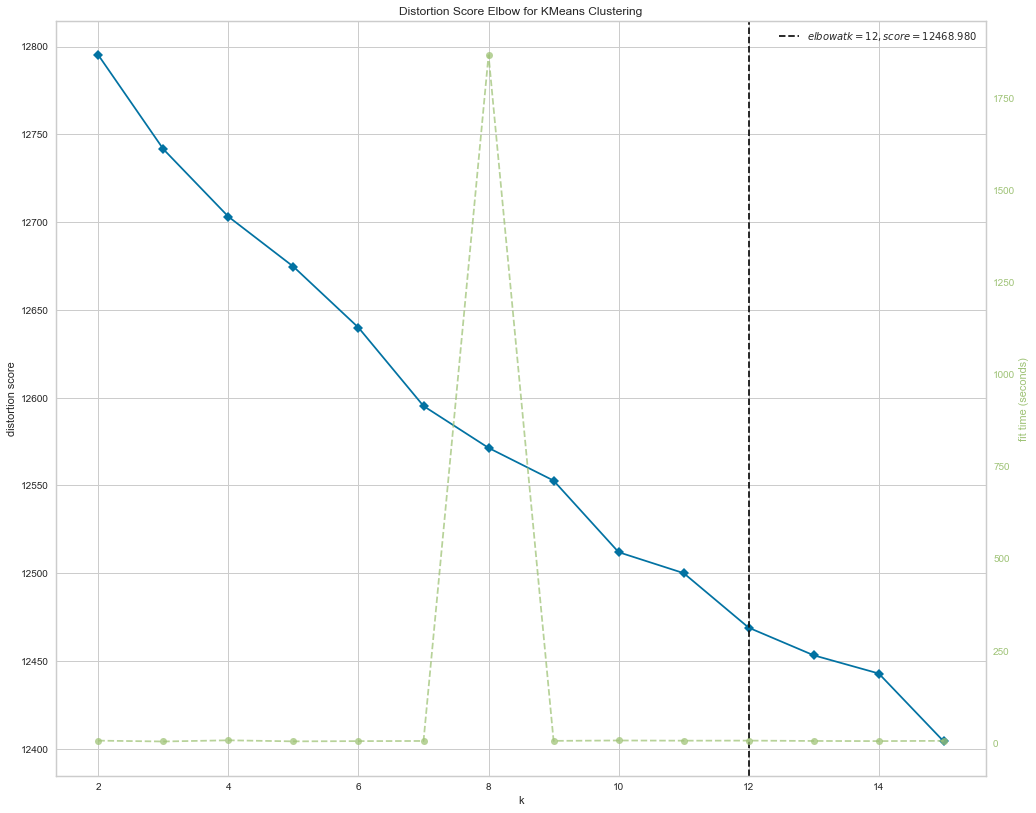

In [30]:
kmeans = KMeans(n_init = 20, n_jobs = -1)
visualizer = KElbowVisualizer(kmeans, size = (1200,1000), k = (2, 16))
visualizer.fit(tfidf)
visualizer.show()

* If we use the Silhouette visualizer, we'll see that the "best" score is always that of the run with the most clusters

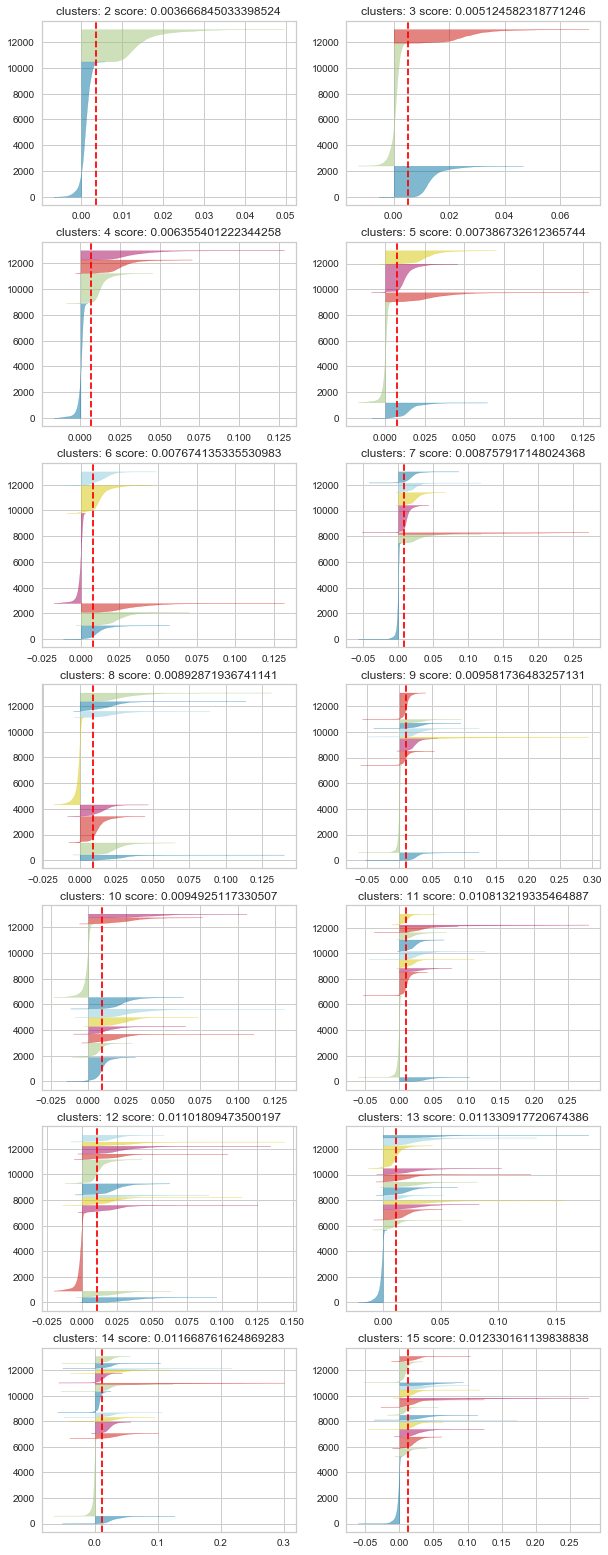

In [34]:
scores = {}
plt.figure(figsize=(2 * 5,  10 * 4))

for n_clusters in range(2, 16):
    plt.subplot(10, 2, n_clusters - 1)
    kmeans = KMeans(n_clusters, n_init = 20, n_jobs = -1)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(tfidf)
    scores[n_clusters] = visualizer.silhouette_score_    
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')

* In order to pick an appropriate amount of clusters, we'll use the scores of the silhouettes and plot them
* We'll use the following plot and the elbow visualizer to pick a number of clusters ourselves

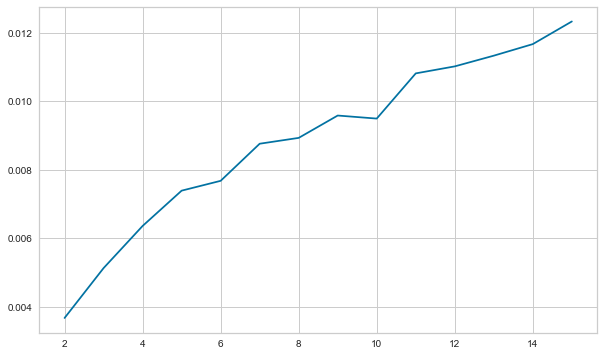

In [42]:
score_list = sorted(scores.items(), key=lambda kv: kv[0], reverse=False)
x, y = zip(*score_list)
plt.figure(figsize = (10,6))
plt.plot(x, y)
plt.show()

* To check that the amount is appropriate, we'll run an InterclusterDistance visualizer and see if any groups fall on top of each other

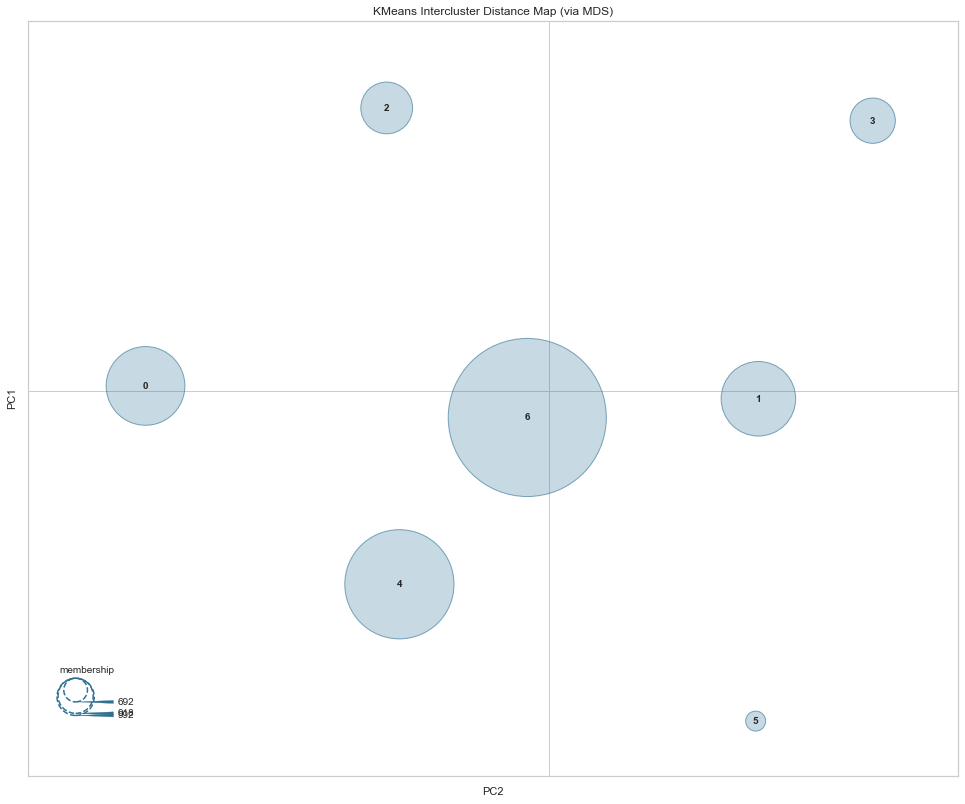

In [47]:
kmeans = KMeans(n_jobs = -1, n_clusters = 7, n_init = 20).fit(tfidf)
visualizer = InterclusterDistance(kmeans, size = (1200,1000))
visualizer.fit(tfidf)
visualizer.show()

* We can discern if the clusters make sense by printing the most important features of the clusters
* In almost every run, most clusters concern topics of the UK and Greece

In [48]:
clusters = KMeans(n_clusters = 7, n_init = 20, n_jobs = -1).fit_predict(tfidf)
text_clust = pd.DataFrame(tfidf.todense()).groupby(clusters).mean()
    
for i,r in text_clust.iterrows():
    print('\nCluster {}'.format(i))
    print(', '.join([vec.get_feature_names()[j] for j in np.argsort(r)[-20:]]))


Cluster 0
member, labour, trade, policy, want, migration, people, control, support, meps, turkey, need, borders, britain, membership, cameron, referendum, leave, uk, eu

Cluster 1
report, new, campaign, eppgroup, people, good, europarl_en, theprogressives, vote, labour, eurolabour, eu, debate, meeting, day, meps, great, support, ep, today

Cluster 2
crisis, political, good, juncker, migration, want, fight, digital, work, says, needs, future, refugees, greece, change, people, need, eu, eppgroup, europe

Cluster 3
campaign, policies, tories, just, farage, eu, lab, voters, policy, uk, immigration, election, people, poll, today, party, vote, nhs, labour, ukip

Cluster 4
greece, president, attack, great, europarl_en, migration, members, comilara, stand, manfredweber, eu, commission, new, just, meeting, epp, union, parliament, eppgroup, european

Cluster 5
european, negotiations, eppgroup, parliament, today, berndlange, eurolabour, good, labour, ep, jude_kd, malmstromeu, meps, public, eu, d

## Classification

* We'll be testing a couple of classification models to find those with greater accuracy
* For some of them, we'll run a grid search for hyperparameter tuning

### Preprocess

* Slightly different from the first time. We'll drop words that contain numericals and are shorter than two letters
* We'll be splitting the dataset to a train and a test set (70:30)

In [12]:
vec = TfidfVectorizer(lowercase = True, strip_accents = 'unicode', stop_words = 'english', min_df = 5, max_df = 0.7, token_pattern=r'(?u)\b[A-Za-z]\w\w+\b')
tfidf = vec.fit_transform(df['text']).toarray()

X_train, X_test, y_train, y_test = train_test_split(tfidf, df['origMepGroupId'], test_size = 0.3)

### Dummy Classifier

* Our baseline. Any model with values close the dummy's score will not be used further

In [13]:
dummy_classifier = DummyClassifier(strategy = 'most_frequent')
dc_fitted = dummy_classifier.fit(X_train, y_train)
y_pred_dummy = dummy_classifier.predict(X_test)

print('Dummy Classifier accuracy score: ' + str(round(accuracy_score(y_test, y_pred_dummy), 4)))

Dummy Classifier accuracy score: 0.2635


### Multinomial Naive Bayes

In [14]:
mnb = MultinomialNB().fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)

print('Multinomial Naive Bayes accuracy score: ' + str(round(accuracy_score(y_test, y_pred_mnb), 4)))

Multinomial Naive Bayes accuracy score: 0.652


### Logistic Regression

In [15]:
lr = LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial', class_weight = 'balanced', max_iter = 200).fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print('Logistic regression accuracy score: ' + str(round(accuracy_score(y_test, y_pred_lr), 4)))

Logistic regression accuracy score: 0.6823


### LightGBM

* To find the best hyperparameteres, we'll run a grid search
* <b> WARNING :</b> Do not run unless you have the spare time!

In [249]:
model = lgb.LGBMClassifier(n_jobs = -1)
param_grid = {
    'objective' :     ['multiclass', 'multiclassova'],
    'n_estimators' :  [220, 550, 560],
    'learning_rate' : [1, 0.1, 0.2],
    'num_classes':    [7],
    'reg_alpha':      [0, 0,5],
    'reg_lambda':     [0, 0.5],
    'colsample_bytree': [1, 0.7]
}

gridgbm = GridSearchCV(model, param_grid, cv=5, scoring = 'accuracy', n_jobs = -1, verbose = 10)
gridgbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gridgbm.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed: 1

Best parameters found by grid search are: {'colsample_bytree': 1, 'learning_rate': 0.2, 'n_estimators': 220, 'num_classes': 7, 'objective': 'multiclassova', 'reg_alpha': 0, 'reg_lambda': 0}


In [16]:
lgbm = lgb.LGBMClassifier(objective = 'multiclassova', learning_rate = 0.2, n_estimators = 220, num_classes = 7, n_jobs = -1)
lgbm = lgbm.fit(X_train, y_train)
y_pred_lgb = lgbm.predict(X_test)

print('LightGBM accuracy score: ' + str(round(accuracy_score(y_test, y_pred_lgb), 4)))

LightGBM accuracy score: 0.651


### XGBoost 

* XGBoost generally shares parameteres with lightgbm
* Slower than LightGBM

In [21]:
xg_clas = xgb.XGBClassifier(objective = 'multi:softmax', num_class = 7, n_estimators = 560, learning_rate = 0.1, n_jobs = -1, verbosity = 1)
xg_clas = xg_clas.fit(X_train, y_train)
y_pred_xgb = xg_clas.predict(X_test)

print('XGBoost accuracy score: ' + str(round(accuracy_score(y_test, y_pred_xgb), 4)))

XGBoost accuracy score: 0.6389


### AdaBoost 

* Extremely slow and not accurate enough

In [72]:
ada = AdaBoostClassifier(n_estimators = 500)
ada = ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)

print('AdaBoost accuracy score: ' + str(round(accuracy_score(y_test, y_pred_ada), 4)))

XGBoost accuracy score: 0.4286


### K Nearest Neighbors

* During testing, KNN did not seem accurate or trustworthy enough

In [17]:
knn = KNeighborsClassifier(n_neighbors = 7, algorithm = 'auto', weights = 'distance', n_jobs = -1)
knn = knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print('KNN accuracy score: ' + str(round(accuracy_score(y_test, y_pred_knn), 4)))

KNN accuracy score: 0.3916


### SGDClassifier

* We'll be running another grid search to find the best hyperparameters

In [92]:
sgd = SGDClassifier(early_stopping = True, n_jobs = -1)

param_grid = {
    'loss' :     ['modified_huber', 'log', 'squared_hinge'],
    'eta0' :  [0.1, 0.2],
    'learning_rate' : ['adaptive', 'optimal'],
    'n_iter_no_change' : [4, 5],
    'max_iter': [500]
}

gridgbm = GridSearchCV(sgd, param_grid, cv=5, scoring = 'accuracy', n_jobs = -1, verbose = 5)
gridgbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gridgbm.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  60 | elapsed:  6.8min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  55 out of  60 | elapsed:  7.0min remaining:   38.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.0min finished


Best parameters found by grid search are: {'eta0': 0.1, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'max_iter': 500, 'n_iter_no_change': 4}


In [18]:
sgd = SGDClassifier(loss = 'modified_huber', eta0 = 0.1, learning_rate = 'adaptive', n_iter_no_change = 4, early_stopping = True, n_jobs = -1)
sgd = sgd.fit(X_train, y_train)
y_pred_sgd = sgd.predict(X_test)

print('SGDClassifier accuracy score: ' + str(round(accuracy_score(y_test, y_pred_sgd), 4)))

SGDClassifier accuracy score: 0.706


### Multi Layer Perceptron

* Sklearn's adaptation of neural networks

In [19]:
mlp = MLPClassifier(hidden_layer_sizes=(128, 32,), solver='adam', learning_rate = 'adaptive', early_stopping = True).fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

print('MLPClassifier accuracy score: ' + str(round(accuracy_score(y_test, y_pred_mlp), 4)))

MLPClassifier accuracy score: 0.7039


### Voting Classifier

* Now that we've run through our classifier models, we'll combine the results through sklearn's Voting Classifier

In [28]:
estimators=[('multinomial_nb', mnb), ('logistic_regression', lr), ('lightgbm', lgbm), ('xgboost', xg_clas), ('sgdclassifier', sgd), ('multilayer_perceptron', mlp)]
vclf = VotingClassifier(estimators, voting = 'soft', n_jobs = -1).fit(X_train, y_train)
vclf.fit(X_train, y_train)

y_pred_vote = vclf.predict(X_test)
print('Voting classifier accuracy score: ' + str(round(vclf.score(X_test, y_test), 4)))

Voting classifier accuracy score: 0.7139


* In most of the runs of the classification models, the voting classifier generally provides an 70%+ accuracy
* We'll create a plot to see check which predictions are mostly wrong, if they exist. <br>
  We'll count the correct predictions along with wrong ones and create a barplot

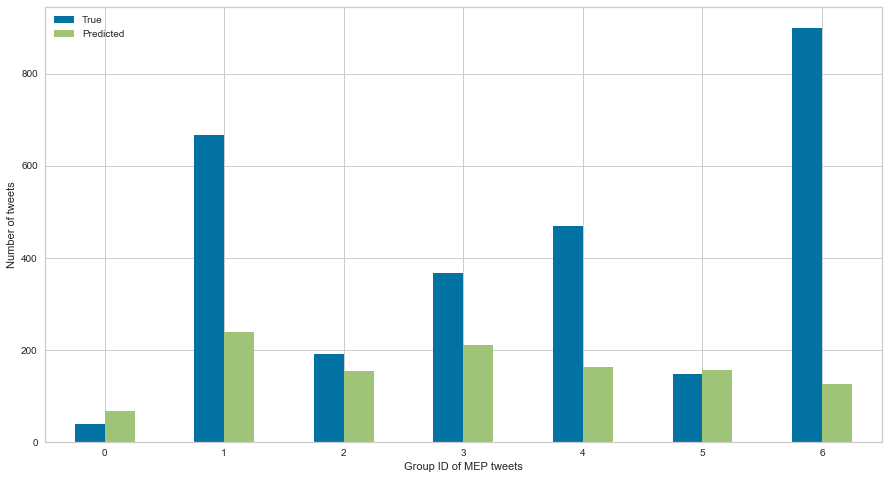

In [29]:
comp = pd.DataFrame()
temp = pd.DataFrame()
temp['True'] = y_test
temp['Predicted'] = y_pred_vote

temp = temp.reset_index().groupby(['True', 'Predicted']).count().reset_index()
comp['True'] = temp[temp['True'] == temp['Predicted']]['index']
comp = comp.reset_index(drop = True)
for i in range(7):
    comp.loc[i, 'Predicted'] = temp[(temp['True'] != temp['Predicted']) & (i == temp['True']) & (i != temp['Predicted'])]['index'].sum()

ax = comp.plot(kind = 'bar', figsize = (15, 8), rot = 0)
ax.set_xlabel("Group ID of MEP tweets")
ax.set_ylabel("Number of tweets")
plt.show()

* As expected, the largest amounts of wrong predictions in relation to the total number of predictions are those of groups 0, 2 and 5
* We can safely assume that it might not be possible to achieve higher accuracies on those groups without enriching our dataset with more tweets
* Note: these observations were made with the tweets of "tweets.csv". Although unlikely, it might be possible that a new download of tweets might provide different results